In [1]:
!kaggle datasets download -d lamsimon/celebahq

Dataset URL: https://www.kaggle.com/datasets/lamsimon/celebahq
License(s): unknown
 99% 2.54G/2.55G [00:25<00:00, 165MB/s]
100% 2.55G/2.55G [00:25<00:00, 108MB/s]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

*Equalized Learning Rate*


---

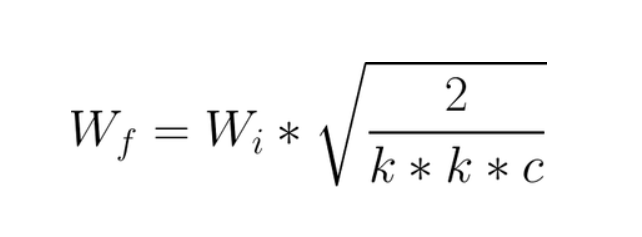

In [3]:
class WSConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.weightshift=(gain/ (kernel_size * kernel_size * in_channels))**0.5

    self.bias=self.conv.bias
    self.conv.bias= None

    nn.init.normal_(self.conv.weight)
    nn.init.zeros_(self.bias)

  def forward(self, x):
    return self.conv(x * self.weightshift)  + self.bias.view(1,self.bias.shape[0],1,1)

*PixelNorm*


---

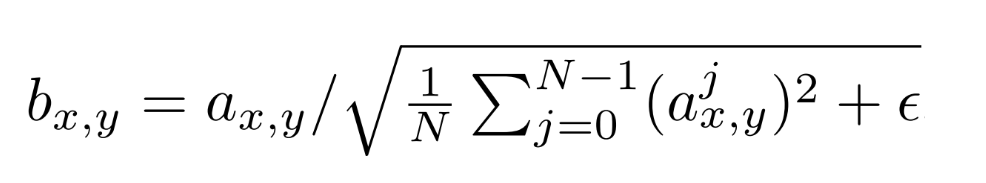

In [4]:
class PixelNorm(nn.Module):
  def __init__(self):
    super().__init__()
    self.epsilon=1e-8


  def forward(self,x):
    return x/torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+self.epsilon)

*Conv Layer* : : >
Used Multiple times in Discriminator and Generator.


---

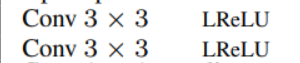

In [5]:
class Convl(nn.Module):
  def __init__(self, inch, outch, use_pn=True):
    super().__init__()

    self.conv1=WSConv(inch,outch)
    self.conv2=WSConv(outch,outch)
    self.pn=PixelNorm()
    self.use_pn=use_pn
    self.lrelu=nn.LeakyReLU(0.2)


  def forward(self,x):
    x=self.lrelu(self.conv1(x))
    if self.use_pn:
      x=self.pn(x)
    x=self.lrelu(self.conv2(x))
    if self.use_pn:
      x=self.pn(x)
    return x

**Generator**

---
*Architecture*
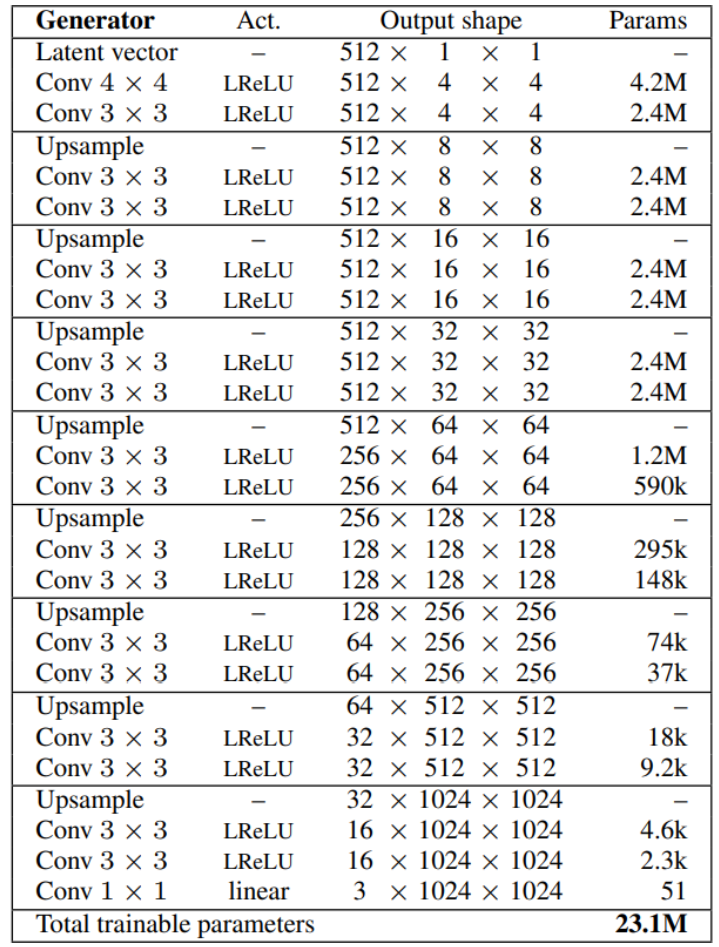

In [19]:
class Generator(nn.Module):
  def __init__(self, zdim, imgch, inch):
    super().__init__()
    self.initial_layer=nn.Sequential(
        #Instead of applying equalized learning rate to convTranspose, we are doing a pixelnorm
        PixelNorm(),
        nn.ConvTranspose2d(zdim,inch,4,1,0),
        nn.LeakyReLU(0.2),
        WSConv(inch,inch),
        nn.LeakyReLU(0.2),
        PixelNorm(),
    )

    self.channel_factors=[1 ,1 ,1 ,1 ,1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

    self.initial_Torgb= WSConv(inch,imgch,1,1,0)

    self.progresslayers, self.torgblayers = (
        nn.ModuleList(),
        nn.ModuleList([self.initial_Torgb]),
    )

    for i in range(len(self.channel_factors) -1):
      self.progresslayers.append(
          Convl(int(inch*self.channel_factors[i]), int(inch * self.channel_factors[i+1]))
      )
      self.torgblayers.append(
          WSConv(int(inch * self.channel_factors[i+1]), imgch, kernel_size=1, stride=1, padding=0)
      )


  def fade(self, generated,upscaled,alpha):
    return torch.tanh(alpha*generated + (1-alpha)*upscaled)

  def forward(self,x,alpha, steps):
    out=self.initial_layer(x)

    if steps==0:
      return self.initial_Torgb(out)

    for step in range(steps):
      upscale=F.interpolate(out, scale_factor=2, mode="nearest")
      out=self.progresslayers[step](upscale)

    upscaledOut=self.torgblayers[steps-1](upscale)
    finalOut = self.torgblayers[steps](out)
    return self.fade(finalOut,upscaledOut,alpha)


**Discriminator**

---

*Architecture*

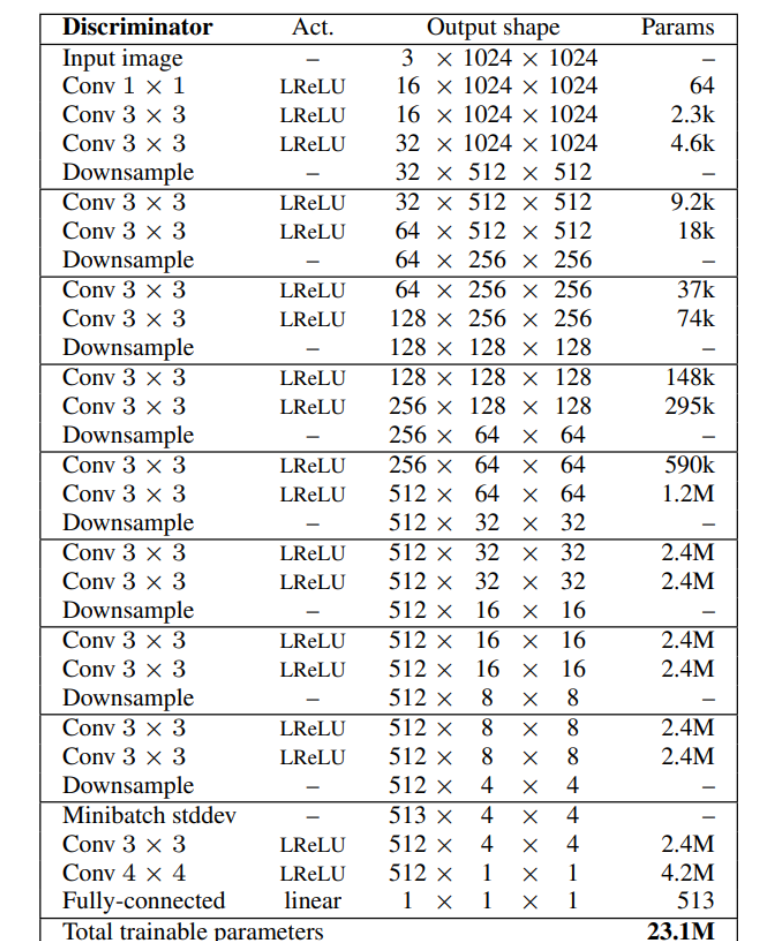

In [7]:
class Discriminator(nn.Module):
  def __init__(self, imgch, inch):
    super().__init__()
    self.channel_factors=[1 ,1 ,1 ,1 ,1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]
    self.progesslayers, self.fromrgb= (nn.ModuleList() , nn.ModuleList())

    for i in range(len(self.channel_factors) - 1, 0, -1):
            conv_in = int(inch * self.channel_factors[i])
            conv_out = int(inch * self.channel_factors[i - 1])
            self.progesslayers.append(Convl(conv_in, conv_out, use_pn=False))
            self.fromrgb.append(
                WSConv(imgch, conv_in, kernel_size=1, stride=1, padding=0)
            )

    self.fromrgb.append(WSConv(imgch, inch))

    self.initial_fromrgb = WSConv(
            imgch, inch, kernel_size=1, stride=1, padding=0
        )
    self.fromrgb.append(self.initial_fromrgb)
    self.downscale = nn.AvgPool2d(
            kernel_size=2, stride=2
        )
    self.leaky = nn.LeakyReLU(0.2)

    self.final_block = nn.Sequential(
            WSConv(inch + 1, inch, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv(inch, inch, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv(
                inch, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

  def minibatchstd(self,x):
    out= torch.std(x,dim=0).mean().repeat(x.shape[0],1,x.shape[2],x.shape[3])
    return torch.cat([x,out], dim=1)

  def fade(self, alpha, downscaled, out):
    return alpha * downscaled + (1 - alpha) * out

  def forward(self, x, alpha, reverse_steps):
    #steps are reversed
    steps=len(self.progesslayers) - reverse_steps

    #rgb to req channels
    out=self.leaky(self.fromrgb[steps](x))

    if reverse_steps==0:
      out=self.minibatchstd(out)
      return self.final_block(out).view(out.shape[0],-1) # Same batch size. removing extra dims

    downscaled=self.leaky(self.fromrgb[steps+1](self.downscale(x))) #again fromrgb for fadin'
    out=self.downscale(self.progesslayers[steps](out))

    out= self.fade(alpha, downscaled,out)

    for step in range(steps+1, len(self.progesslayers)):
      out = self.progesslayers[step](out)
      out = self.downscale(out)

    out=self.minibatchstd(out)
    return self.final_block(out).view(out.shape[0],-1)




In [20]:
# test for gen and disc
from math import log2
zdim=100
inch=256
imgch=3
testgen=Generator(zdim, imgch, inch)
testdisc=Discriminator(imgch, inch)


for img_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    num_steps = int(log2(img_size / 4))
    print(num_steps)
    x = torch.randn((1, zdim, 1, 1))
    z = testgen(x, 0.5, steps=num_steps)
    assert z.shape == (1, 3, img_size, img_size)
    out = testdisc(z, alpha=0.5, reverse_steps=num_steps)
    assert out.shape == (1, 1)
    print(f"Success! At img size: {img_size}")

0
Success! At img size: 4
1
Success! At img size: 8
2
Success! At img size: 16
3
Success! At img size: 32
4


<ipython-input-7-a706da1ca547>:37: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  out= torch.std(x,dim=0).mean().repeat(x.shape[0],1,x.shape[2],x.shape[3])


Success! At img size: 64
5
Success! At img size: 128
6
Success! At img size: 256
7
Success! At img size: 512
8
Success! At img size: 1024


In [24]:
#hyperparameters
starttrainsize=128
device="cuda" if torch.cuda.is_available() else "cpu"
lr=1e-3
bs_list=[32, 32, 32, 16, 16, 16, 16, 8, 4]
imgch=3
zdim=256
inch=256 #Lower than paper due to less comp power
lmabda_gp=10
prog_epochs=[30] * len(bs_list)
fixed_noise = torch.randn(8, zdim, 1, 1).to(device)
NUM_WORKERS = 4

In [10]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
def get_loader(imgsize):
  trfm=transforms.Compose([
      transforms.Resize((imgsize,imgsize)),
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(0.5),
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
  ])
  bs=bs_list[int(log2(imgsize))]
  celebdataset=datasets.ImageFolder("celeba_hq",transform=trfm)
  return DataLoader(celebdataset, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True), celebdataset


In [11]:
def grad_pn(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    mixed_scores = critic(interpolated_images, alpha, train_step)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [14]:
!unzip celebahq.zip

Streaming output truncated to the last 5000 lines.
  inflating: celeba_hq/train/male/140695.jpg  
  inflating: celeba_hq/train/male/140721.jpg  
  inflating: celeba_hq/train/male/140741.jpg  
  inflating: celeba_hq/train/male/140761.jpg  
  inflating: celeba_hq/train/male/140768.jpg  
  inflating: celeba_hq/train/male/140777.jpg  
  inflating: celeba_hq/train/male/140787.jpg  
  inflating: celeba_hq/train/male/140792.jpg  
  inflating: celeba_hq/train/male/140798.jpg  
  inflating: celeba_hq/train/male/140823.jpg  
  inflating: celeba_hq/train/male/140846.jpg  
  inflating: celeba_hq/train/male/140857.jpg  
  inflating: celeba_hq/train/male/140889.jpg  
  inflating: celeba_hq/train/male/140938.jpg  
  inflating: celeba_hq/train/male/140951.jpg  
  inflating: celeba_hq/train/male/140963.jpg  
  inflating: celeba_hq/train/male/140980.jpg  
  inflating: celeba_hq/train/male/141029.jpg  
  inflating: celeba_hq/train/male/141052.jpg  
  inflating: celeba_hq/train/male/141061.jpg  
  inflati

In [15]:
import os
step= int(log2(starttrainsize /4))

loader,data=get_loader(4 * (2**step))
len(loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


3750

In [16]:
import cv2

In [43]:
from tqdm import tqdm
def train(gen, disc, epoch=prog_epochs, device=device):
  gen=gen.to(device)
  disc=disc.to(device)
  gen.train()
  disc.train()

  opt_gen=torch.optim.Adam(gen.parameters(), lr=lr, betas=(0,0.99))
  opt_disc=torch.optim.Adam(disc.parameters(), lr=lr, betas=(0,0.99))

  scaler_gen=torch.cuda.amp.GradScaler()
  scaler_disc=torch.cuda.amp.GradScaler()

  step= int(log2(starttrainsize /4))

  for epochs in prog_epochs[step:]: #start from the given step size
    alpha=1e-5
    loader,data=get_loader(4 * (2**step))
    print("Image size", 4 * (2**step))
    for epoch in range(epochs):
      loop=tqdm(enumerate(loader))
      for (id, (x,_)) in loop:
        x=x.to(device)
        #print(x.shape)
        cur_batch_size = x.shape[0]

        noise=torch.randn(cur_batch_size, zdim, 1, 1).to(device)

        with torch.cuda.amp.autocast():
          fake=gen(noise, alpha, steps=step)
          #print(fake.shape)
          disc_fake=disc(fake.detach(), alpha, reverse_steps=step)
          disc_real=disc(x, alpha, reverse_steps=step)
          gp=grad_pn(disc, x, fake, alpha, step, device)
          d_loss= (
              -(torch.mean(disc_real) - torch.mean(disc_fake))
                    + lmabda_gp * gp
                    + (0.001 * torch.mean(disc_real ** 2))
                    )

        opt_disc.zero_grad()
        scaler_disc.scale(d_loss).backward()
        scaler_disc.step(opt_disc)
        scaler_disc.update()

        with torch.cuda.amp.autocast():
            gen_fake = disc(fake, alpha, step)
            g_loss = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(g_loss).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        alpha += cur_batch_size / (
            (prog_epochs[step] * 0.5) * len(data)
        )
        alpha = min(alpha, 1)

        if id % 100 == 0:
            os.makedirs("images", exist_ok=True)
            with torch.no_grad():
                faken = gen(fixed_noise, alpha, steps=step).cpu().permute(0,2,3,1).numpy()

                img_grid_fake = torchvision.utils.make_grid(ppf[:8], normalize=True).detach().cpu().permute(1,2,0)
            cv2.imwrite('pic.png',img_grid_fake.numpy())

            loop.set_postfix(
            gp=gp.item(),
            g_loss=g_loss.item(),
            d_loss=d_loss.item(),
        )
    step+=1



In [ ]:
!unzip celebahq.zip

In [39]:
generator=Generator(zdim, imgch, inch)
discriminator=Discriminator(imgch, inch)

In [44]:

train(generator, discriminator)

Image size 128


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2036it [12:33,  2.70it/s, d_loss=-4.62, g_loss=12.9, gp=0.0491]


KeyboardInterrupt: 

In [45]:
ppf=generator(fixed_noise, 1, steps=step)

In [46]:
import torchvision
img_grid_fake = torchvision.utils.make_grid(ppf[:8], normalize=True).detach().cpu().permute(1,2,0)

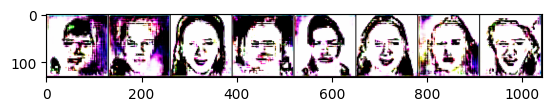

In [47]:
import matplotlib.pyplot as plt
plt.imshow(img_grid_fake)
plt.show()